In [18]:
%matplotlib notebook
import matplotlib.pyplot as plt
from lazy_imports import np
from lazy_imports import plt
from lazy_imports import sitk
from lazy_imports import LinearOperator, gmres
from lazy_imports import loadmat, savemat
from lazy_imports import sitk
from IPython.core.display import display, HTML
plt.rcParams["figure.figsize"] = (4, 4) # (w, h)
%matplotlib notebook
display(HTML("<style>.container { width:55% !important; }</style>"))

In [19]:
from disp.vis import show_2d, show_2d_tensors
from disp.vis import vis_tensors, vis_path, disp_scalar_to_file
from disp.vis import disp_vector_to_file, disp_tensor_to_file
from disp.vis import disp_gradG_to_file, disp_gradA_to_file

In [20]:
from data.io import readRaw, ReadTensors, ReadScalars, WriteTensorNPArray
from data.convert import GetNPArrayFromSITK, GetSITKImageFromNP
import data.gen

In [21]:
from util import diff
from util import tensors
from util import maskops as mo
from util.riemann import riem_vec_norm

In [22]:
from util.tensors import scale_by_alpha

In [23]:
import algo.metricModSolver2d as mms
import algo.geodesic as geo
import algo.euler as euler
import algo.dijkstra as dijkstra

## I/O convention
Due to the certain reason of Kris' simulated data generation, please follow the i/o convention below which is symmetric, to make sure the files are read and written correctly. Following example is for 2D situation, 3D case is analogous.
### Read
Shape of input_tensor.nhdr is [w, h, 3], and Shape of input_mask.nhdr is [w, h]
```
input_tensor = np.transpose(sitk.GetArrayFromImage(sitk.ReadImage(path)),(2,1,0))
input_mask = np.transpose(sitk.GetArrayFromImage(sitk.ReadImage(path)),(1,0))
```
input_tensor.shape is [3, h, w], and input_mask.shape is [h, w]
### Write
output_tensor.shape is [3, h, w], and output_mask.shape is [h, w]
```
output_tensor = sitk.WriteImage(sitk.GetImageFromArray(np.transpose(output_tensor,(2,1,0)), path)
output_mask = sitk.WriteImage(sitk.GetImageFromArray(np.transpose(output_tensor,(2,1,0)), path)
```
Shape of output_tensor.nhdr is [w, h, 3], and Shape of output_mask.nhdr is [w, h]

## 2D

In [24]:
path = '/home/sci/hdai/Projects/Atlas2D/Output/cubic_12_geodesic_7'

Finding geodesic path from [13, 14] with initial velocity [-0.32249471978109273, -0.946571262881625]
Finding geodesic path from [13, 14] with initial velocity [0.32249472 0.94657126]


<IPython.core.display.Javascript object>


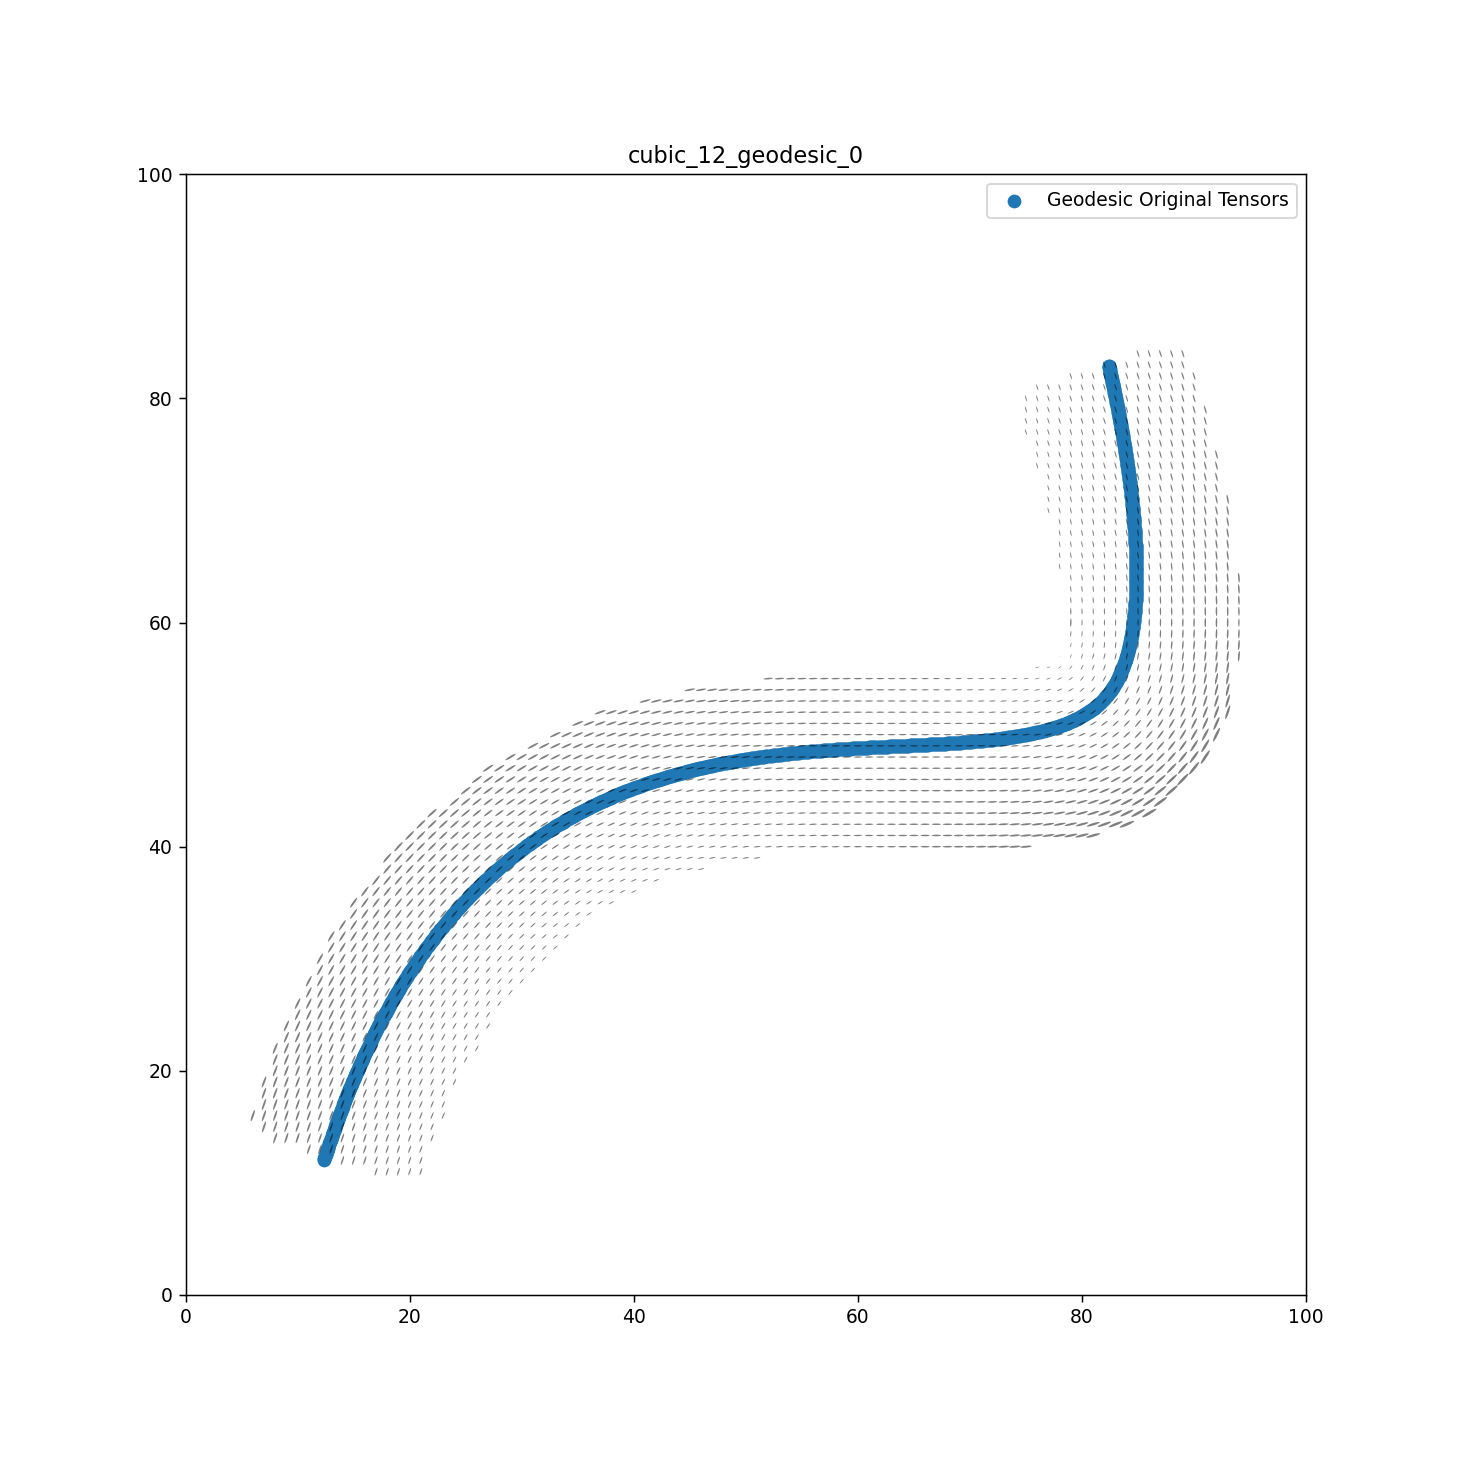

Finding geodesic path from [13, 14] with initial velocity [-0.3093821224294875, -0.95093780149967]
Finding geodesic path from [13, 14] with initial velocity [0.30938212 0.9509378 ]


<IPython.core.display.Javascript object>


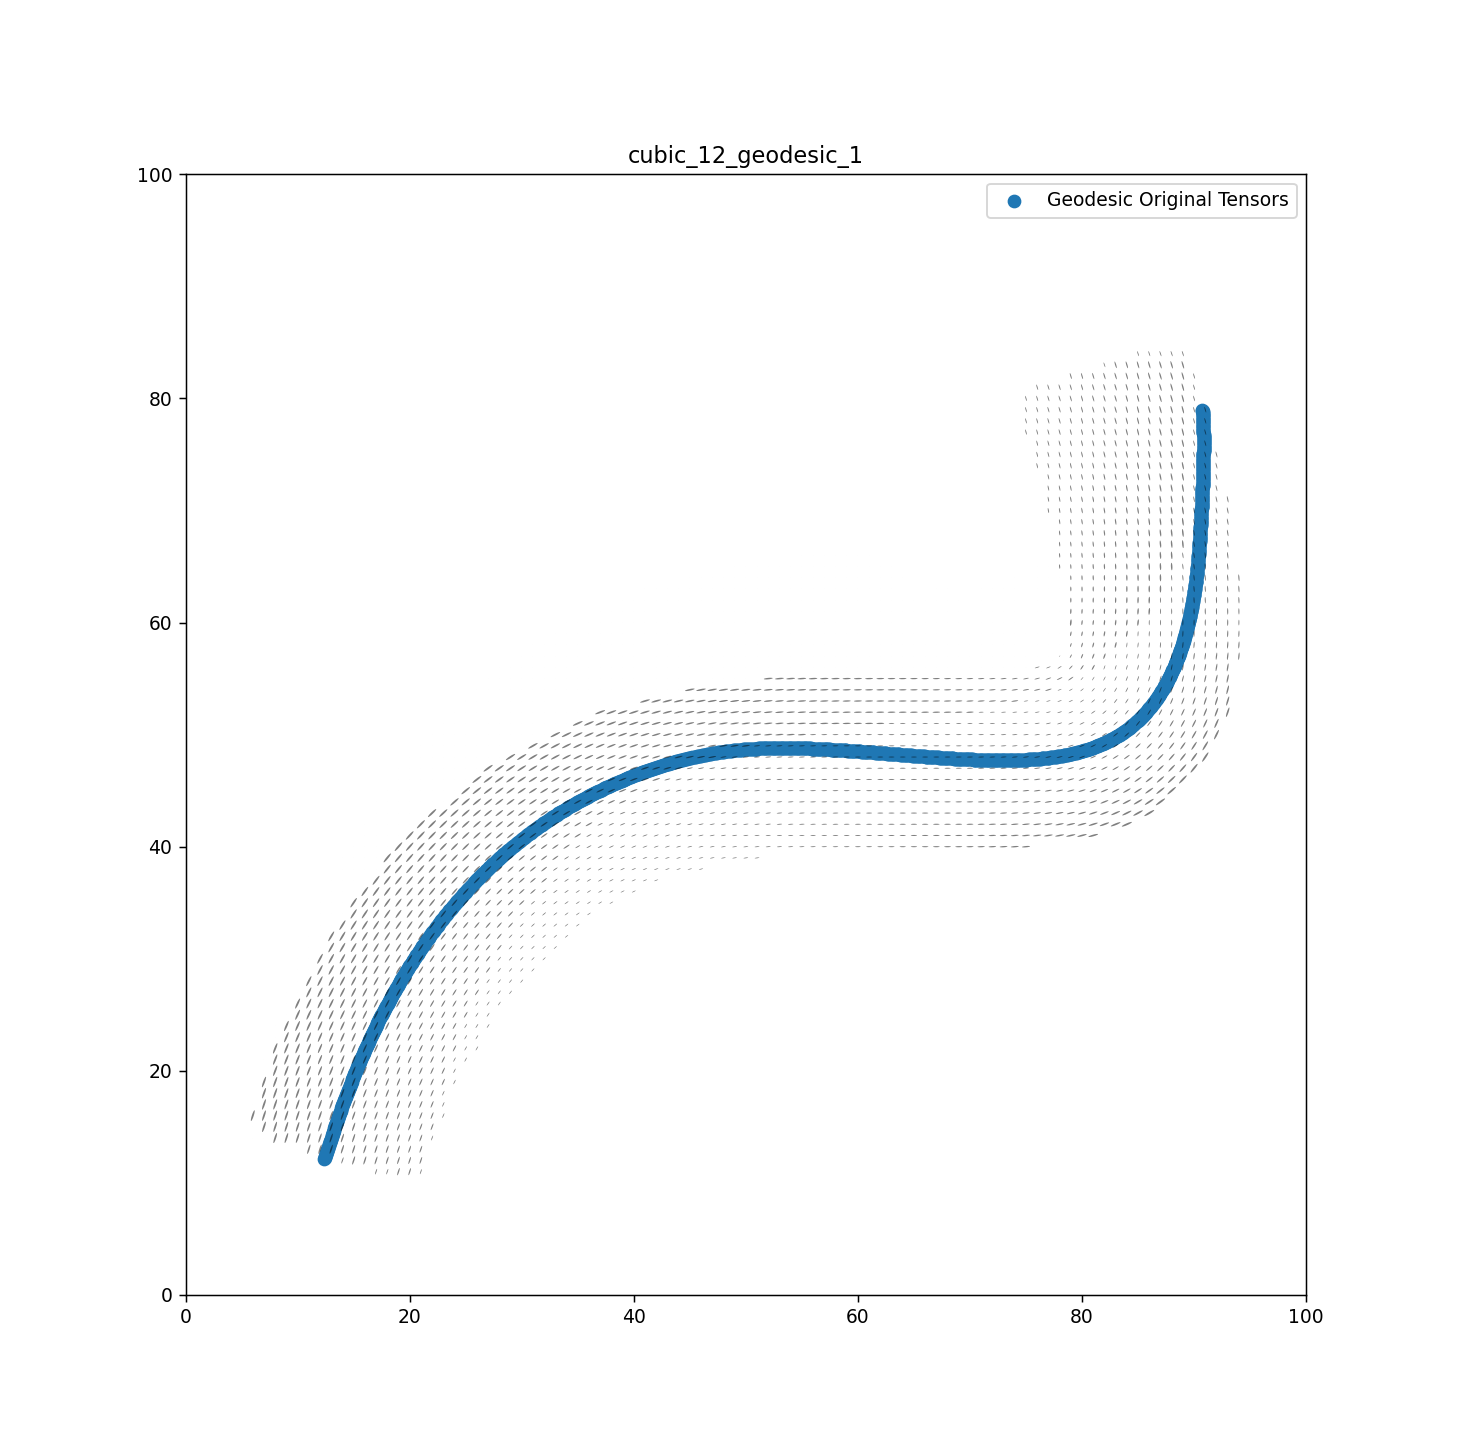

Finding geodesic path from [13, 14] with initial velocity [-0.29535349803156324, -0.9553880422113936]
Finding geodesic path from [13, 14] with initial velocity [0.2953535  0.95538804]


<IPython.core.display.Javascript object>


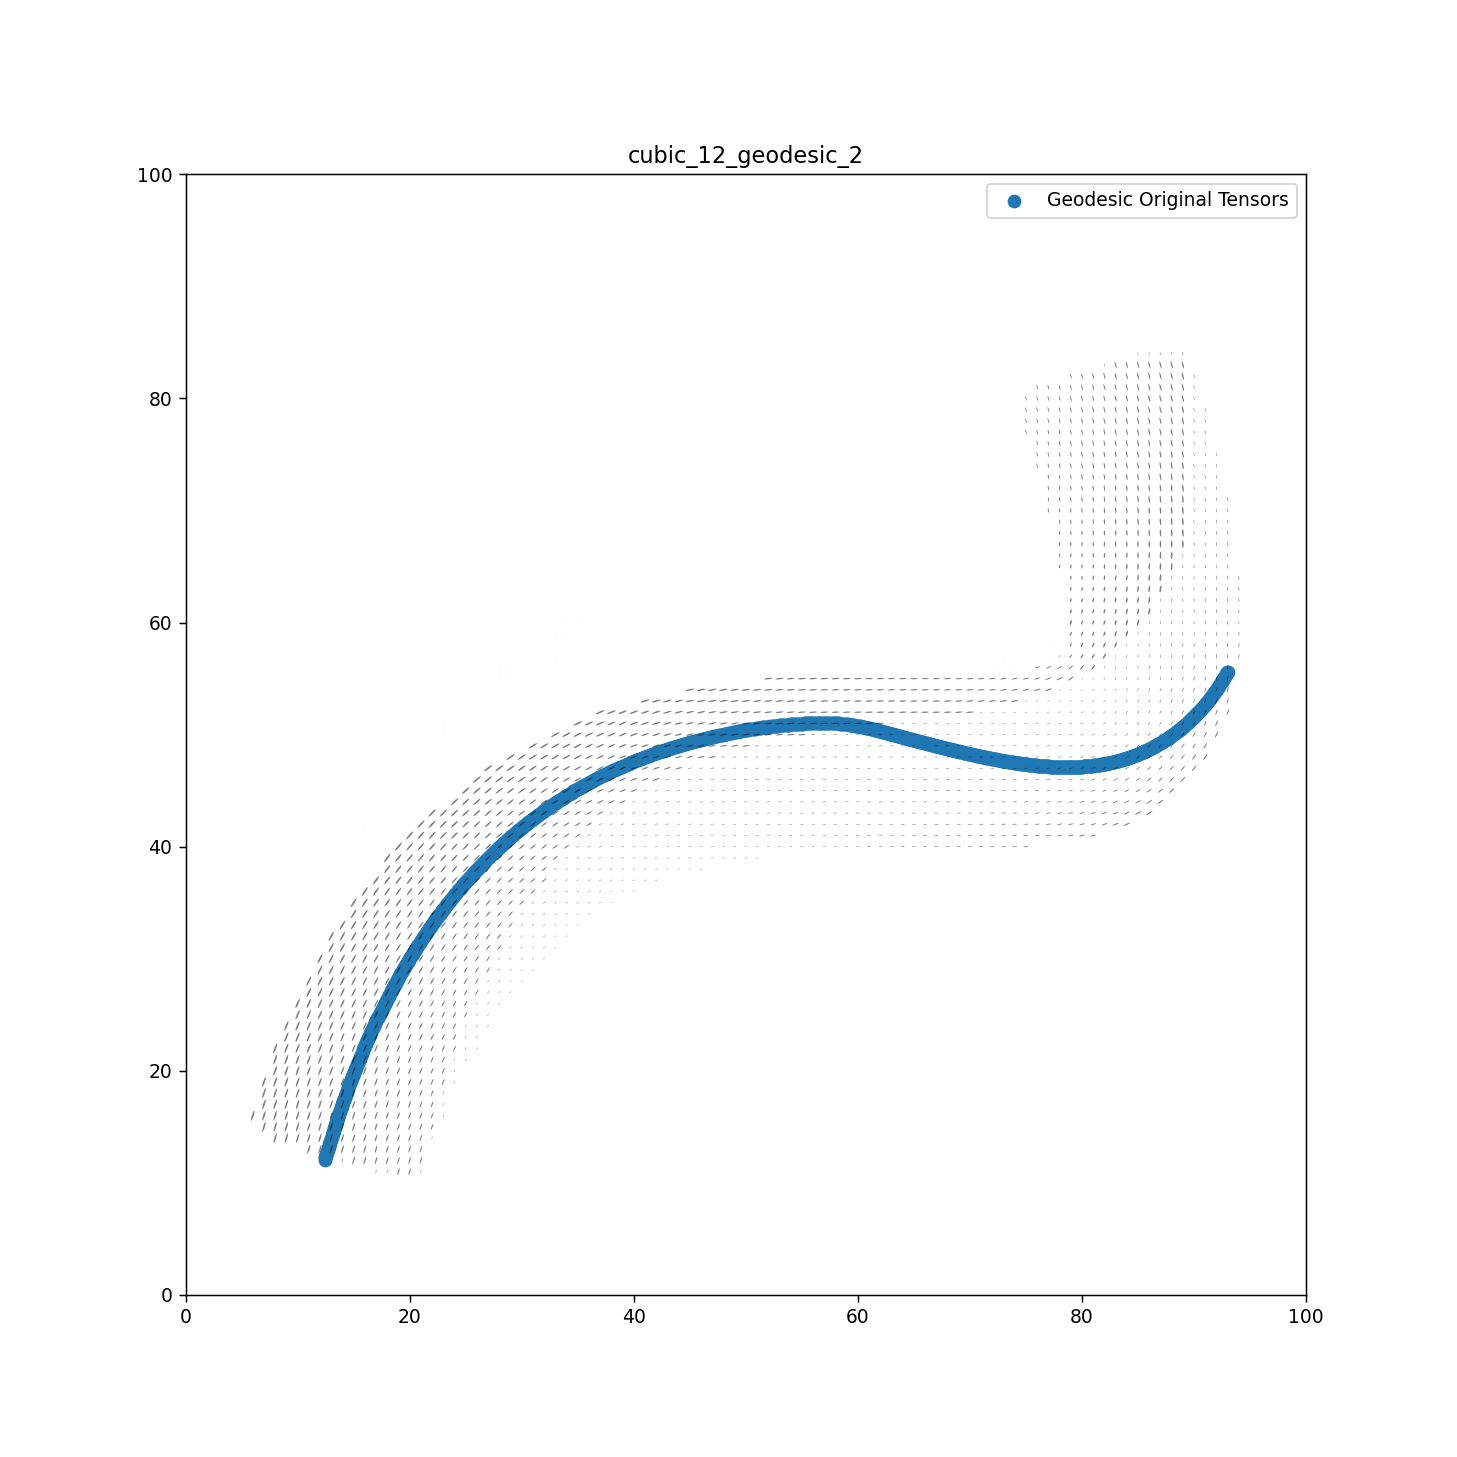

Finding geodesic path from [13, 14] with initial velocity [-0.2803751072611496, -0.959890514188102]
Finding geodesic path from [13, 14] with initial velocity [0.28037511 0.95989051]


<IPython.core.display.Javascript object>


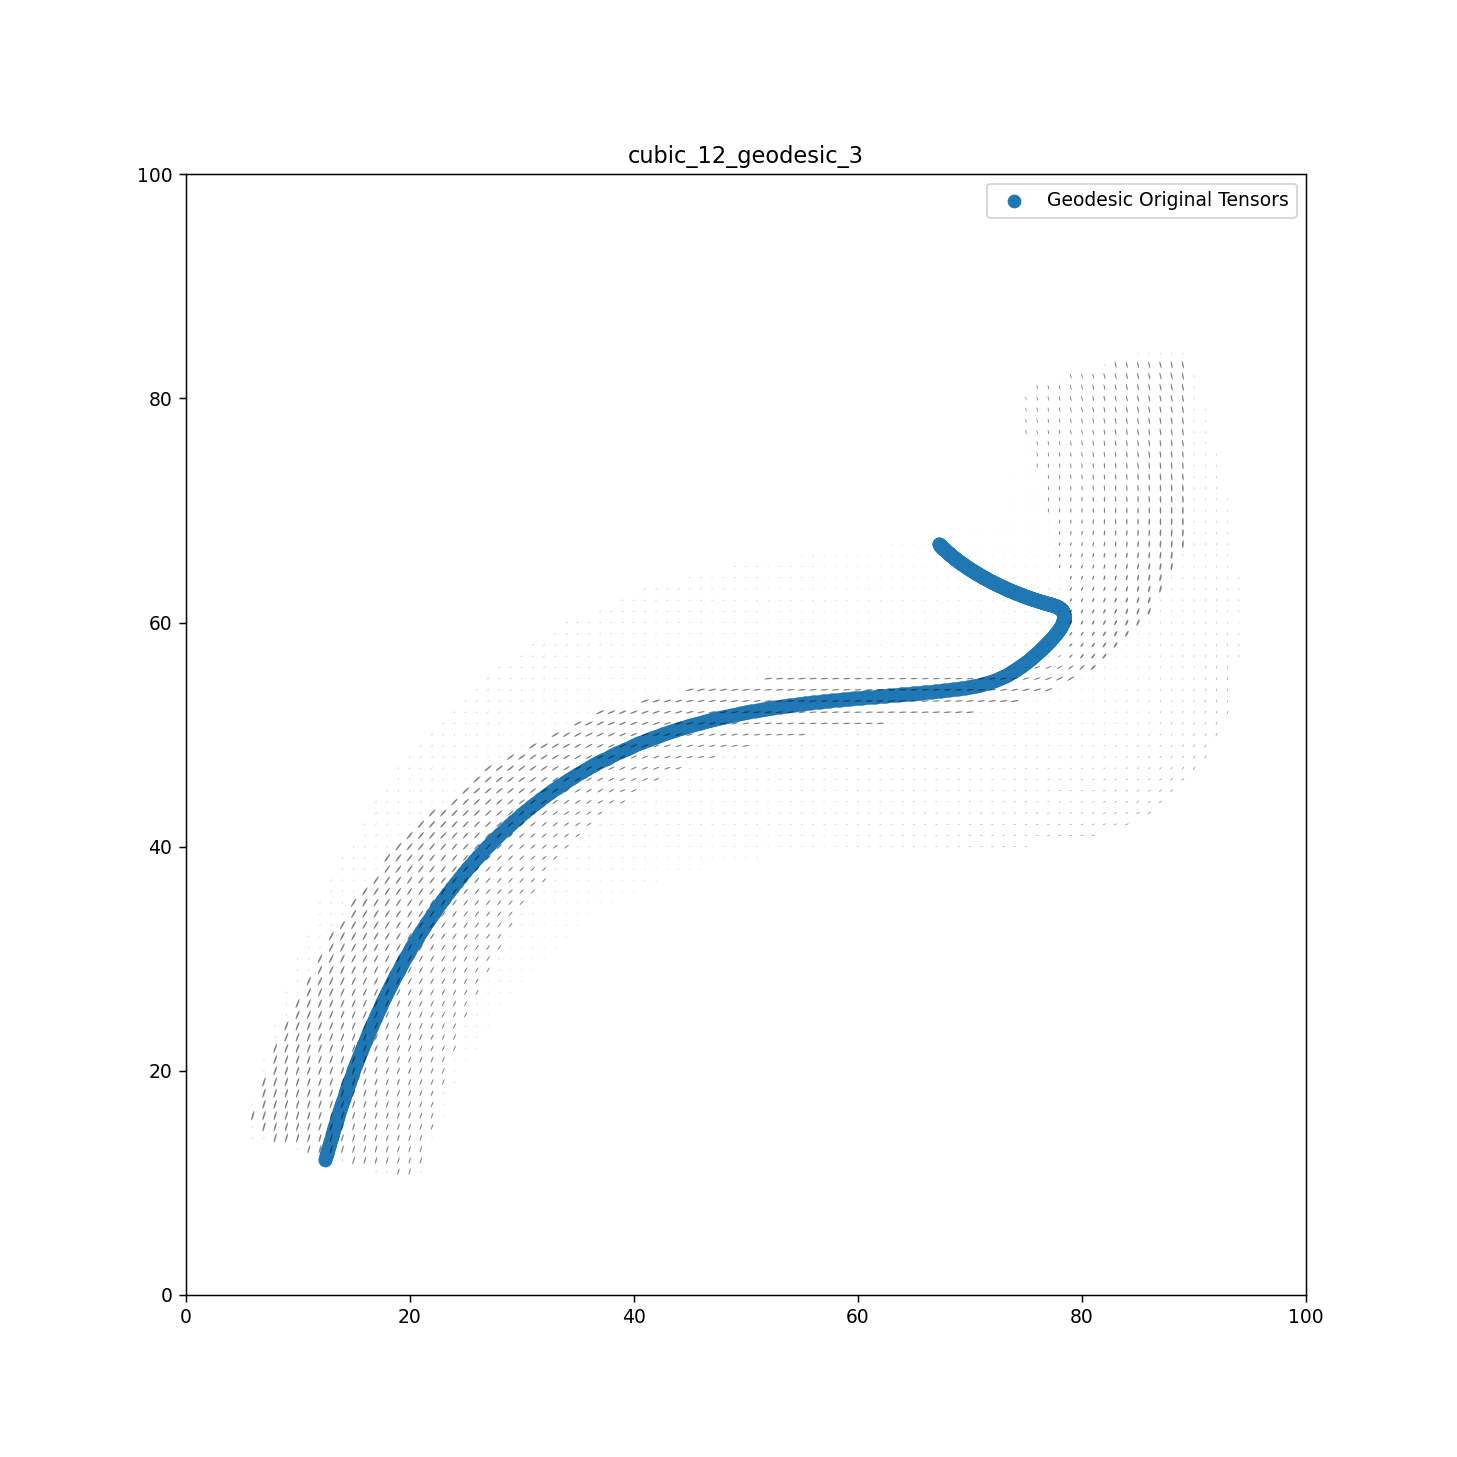

Finding geodesic path from [13, 14] with initial velocity [-0.26442553140445985, -0.9644061065450948]
Finding geodesic path from [13, 14] with initial velocity [0.26442553 0.96440611]


<IPython.core.display.Javascript object>


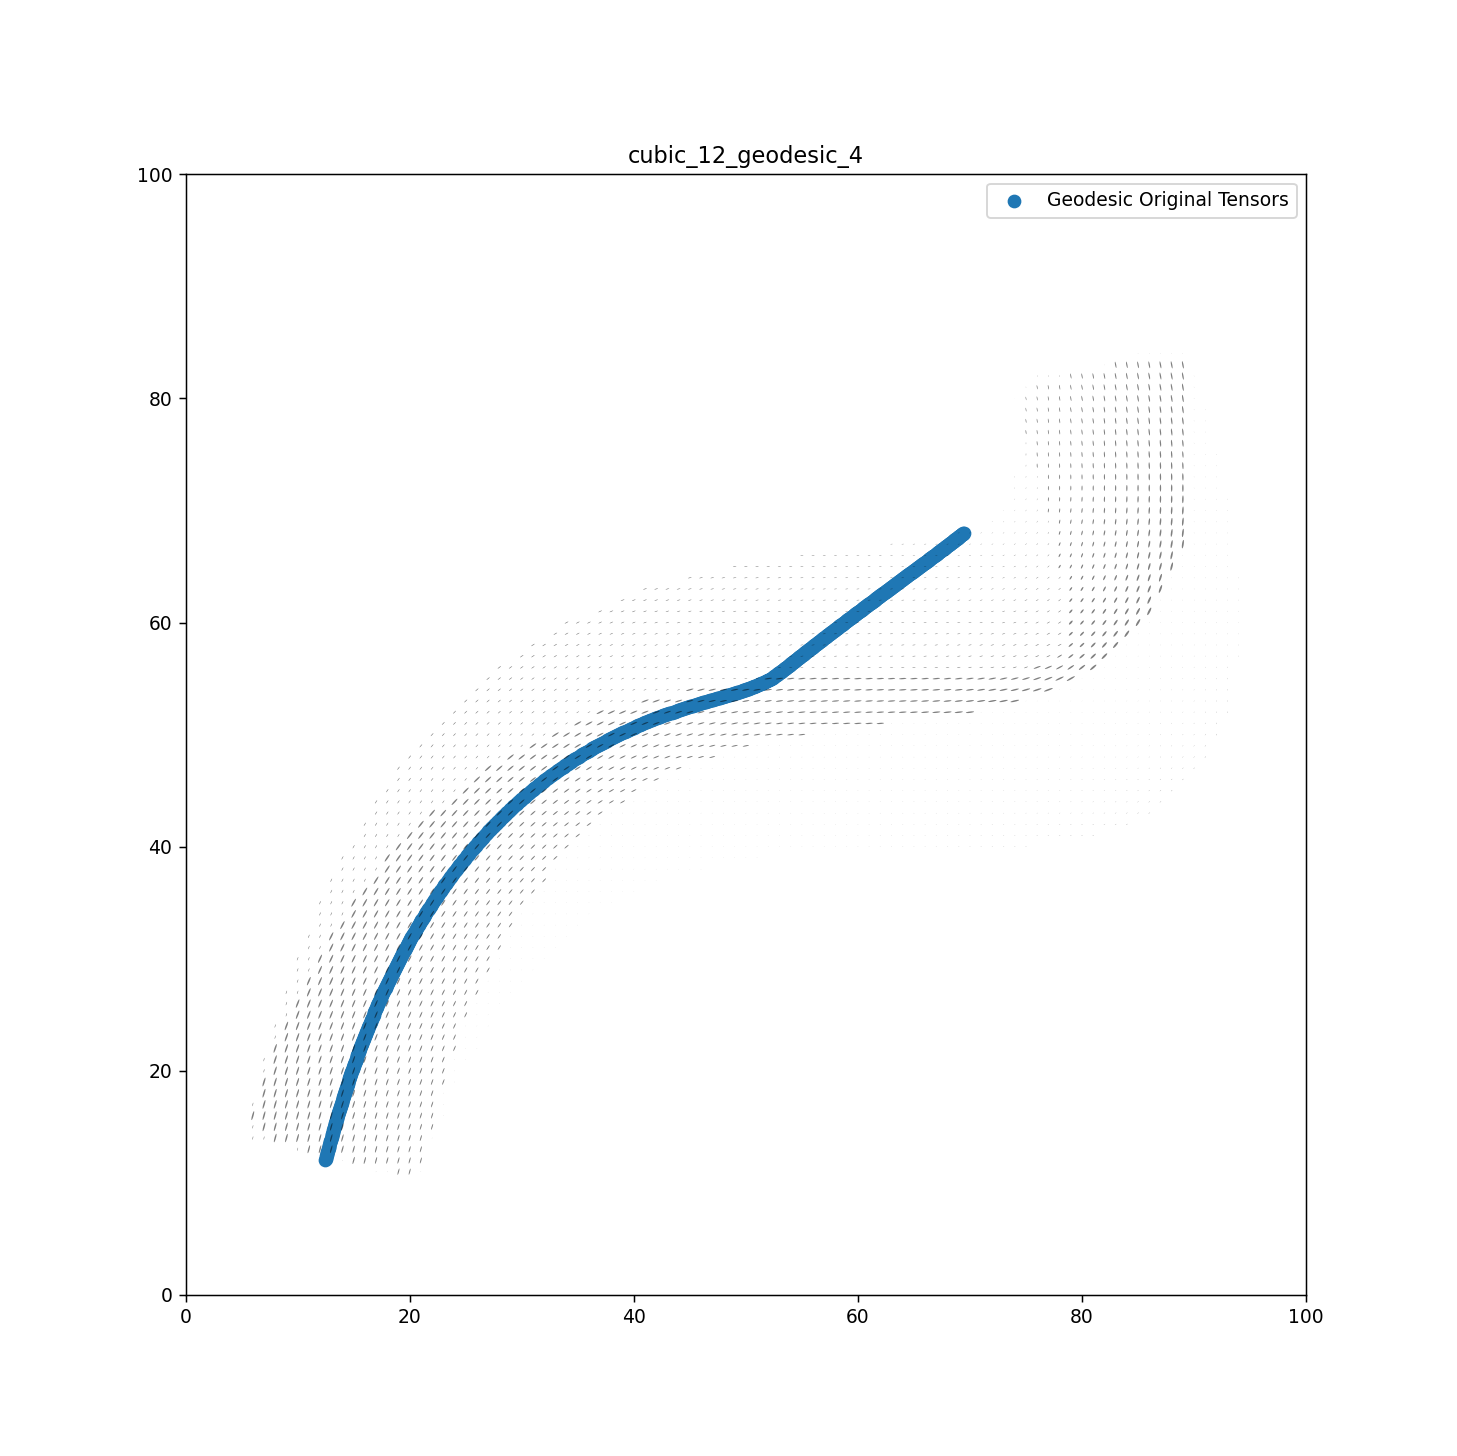

Finding geodesic path from [13, 14] with initial velocity [-0.24750034488521594, -0.9688878053116878]
Finding geodesic path from [13, 14] with initial velocity [0.24750034 0.96888781]


<IPython.core.display.Javascript object>


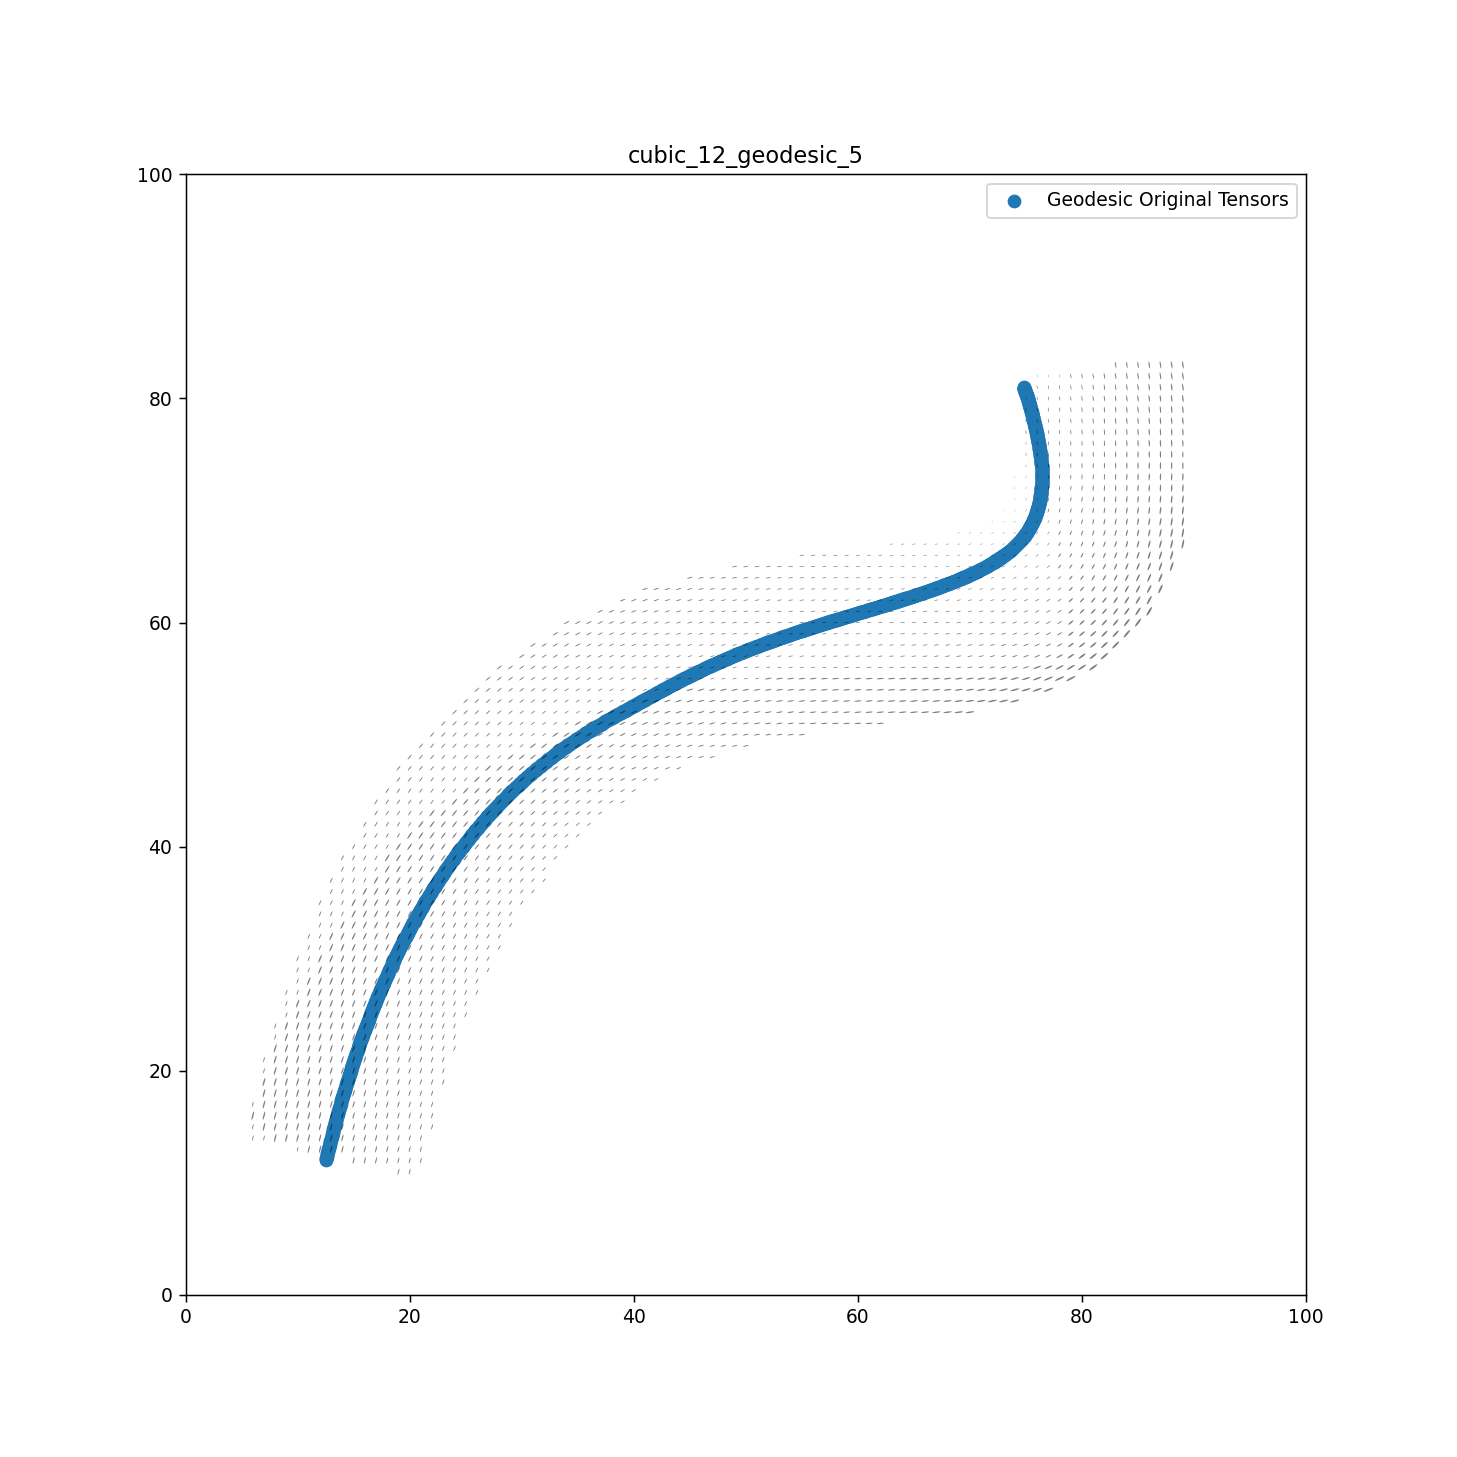

Finding geodesic path from [13, 14] with initial velocity [-0.2296171667110304, -0.9732810266061898]
Finding geodesic path from [13, 14] with initial velocity [0.22961717 0.97328103]


<IPython.core.display.Javascript object>


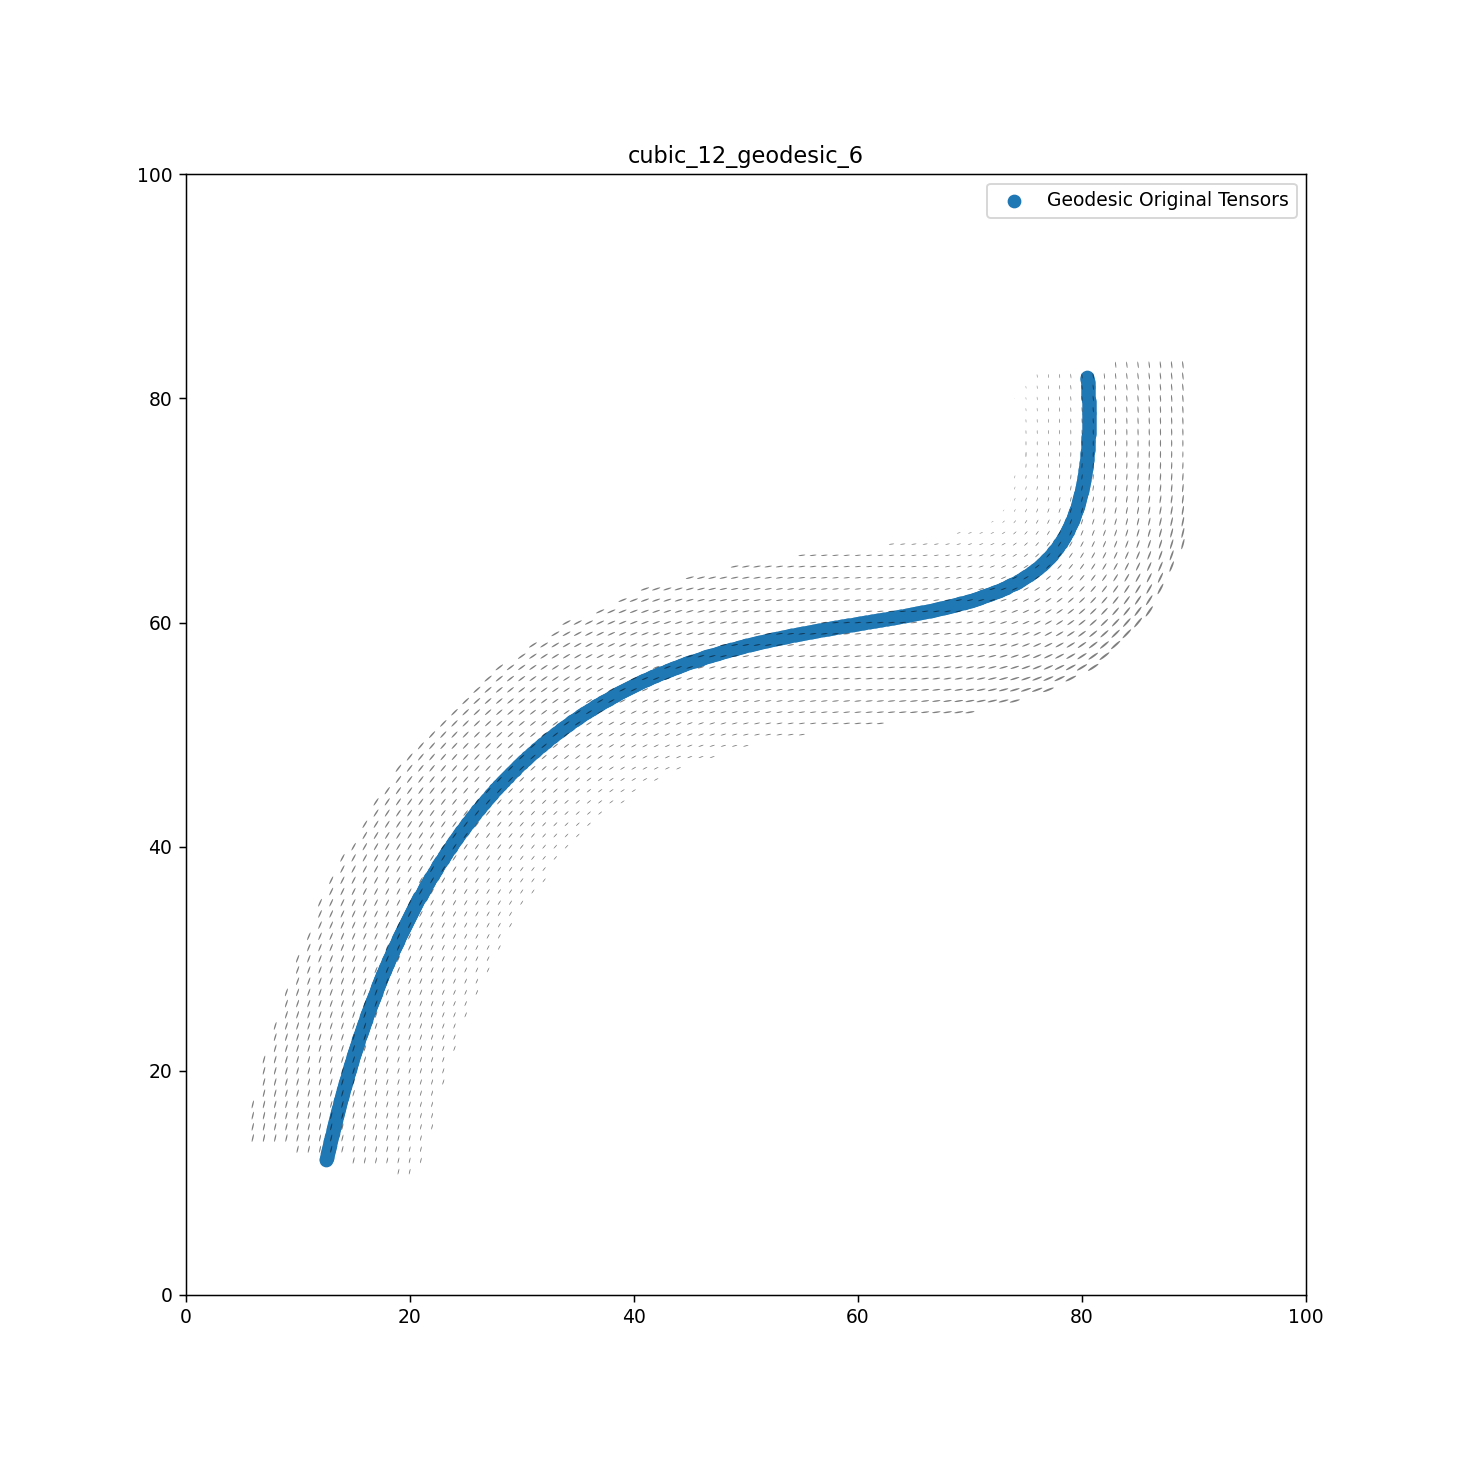

In [26]:
for i in range(7):
    tens_4_path = np.transpose(sitk.GetArrayFromImage(sitk.ReadImage(f'{path}/cubic_12_geodesic_{i}.nhdr')),(2,1,0))
    filt_mask = np.transpose(sitk.GetArrayFromImage(sitk.ReadImage(f'{path}/cubic_12_filt_mask.nhdr')),(1,0))
    start_coords = [[13, 14]]
    init_velocities = [None]
    t1_file = None
    tens_scale = 1e-1
    geo_delta_t = 0.1
    geo_iters = 60000
    geox, geoy = geo.geodesicpath(tens_4_path, filt_mask,\
                                  start_coords[0], init_velocities[0], \
                                  geo_delta_t, iter_num=geo_iters, both_directions=True)
    
    
    tens_fig = vis_tensors(tens_4_path, f'cubic_12_geodesic_{i}', False, scale=tens_scale)
    vis_path(geox, geoy, tens_fig, "Geodesic Original Tensors", 'tab:blue', 40, 1, False)